## 03 비용 최소화하기 - 경사 하강법(Gradient Descent) 소개

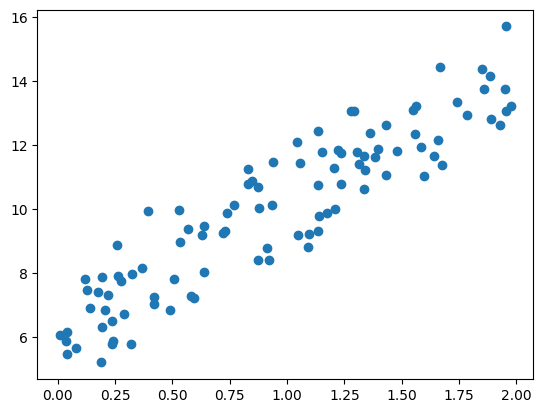

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 6 + 4 * X + np.random.randn(100, 1)

plt.scatter(X, y)

In [2]:
def get_cost(y, y_pred):
    N = len(y)
    cost = np.sum(np.square(y - y_pred)) / N
    return cost

In [3]:
def get_weight_updates(w1, w0, X, y, learning_rate=0.01):
    N = len(y)
    w1_update = np.zeros_like(w1)
    w0_update = np.zeros_like(w0)
    y_pred = np.dot(X, w1.T) + w0
    diff = y - y_pred
    
    w0_factors = np.ones((N, 1))
    w1_update = -(2 / N) * learning_rate * (np.dot(X.T, diff))
    w0_update = -(2 / N) * learning_rate * (np.dot(w0_factors.T, diff))
    
    return w1_update, w0_update

In [4]:
def gradient_descent_steps(X, y, iters=10000):
    w0 = np.zeros((1, 1))
    w1 = np.zeros((1, 1))
    
    for ind in range(iters):
        w1_update, w0_update = get_weight_updates(w1, w0, X, y, learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update
    
    return w1, w0

In [5]:
def get_cost(y, y_pred):
    N = len(y)
    cost = np.sum(np.square(y - y_pred)) / N
    return cost

w1, w0 = gradient_descent_steps(X, y, iters=1000)
print('w1:{0:.3f} w0:{1:.3f}'.format(w1[0, 0], w0[0, 0]))
y_pred = w1[0, 0] * X + w0
print('Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y, y_pred)))

w1:4.022 w0:6.162
Gradient Descent Total Cost:0.9935


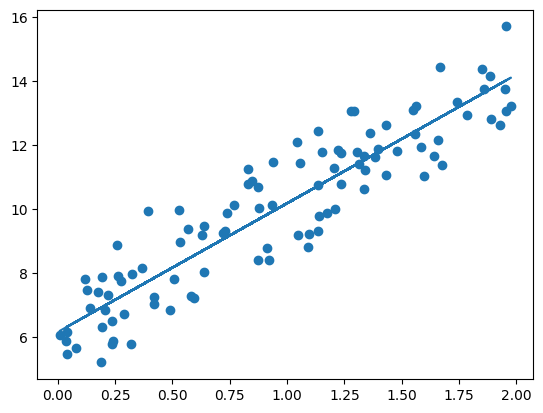

In [6]:
plt.scatter(X, y)
plt.plot(X, y_pred)

In [7]:
def stochastic_gradient_descent_steps(X, y, batch_size=10, iters=1000):
    w0 = np.zeros((1, 1))
    w1 = np.zeros((1, 1))
    
    prev_cost = 100000
    iter_index = 0
    
    for ind in range(iters):
        np.random.seed(ind)
        stochastic_random_index = np.random.permutation(X.shape[0])
        sample_X = X[stochastic_random_index[0:batch_size]]
        sample_y = y[stochastic_random_index[0:batch_size]]
        w1_update, w0_update = get_weight_updates(w1, w0, sample_X, sample_y, learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update
    
    return w1, w0

In [8]:
w1, w0 = stochastic_gradient_descent_steps(X, y, iters=1000)
print('w1:', round(w1[0, 0], 3), 'w0:', round(w0[0, 0], 3))
y_pred = w1[0, 0] * X + w0
print('Stochastic Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y, y_pred)))

w1: 4.028 w0: 6.156
Stochastic Gradient Descent Total Cost:0.9937


## 04 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

#### LinearRegression 클래스 - Ordinary Least Squares

In [9]:
# class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

#### 회기 평가 지표
#### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

bostonDF = pd.read_csv('boston_house_prices.csv', header=1)
bostonDF.rename(columns={'MEDV': 'PRICE'}, inplace=True)
print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [11]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


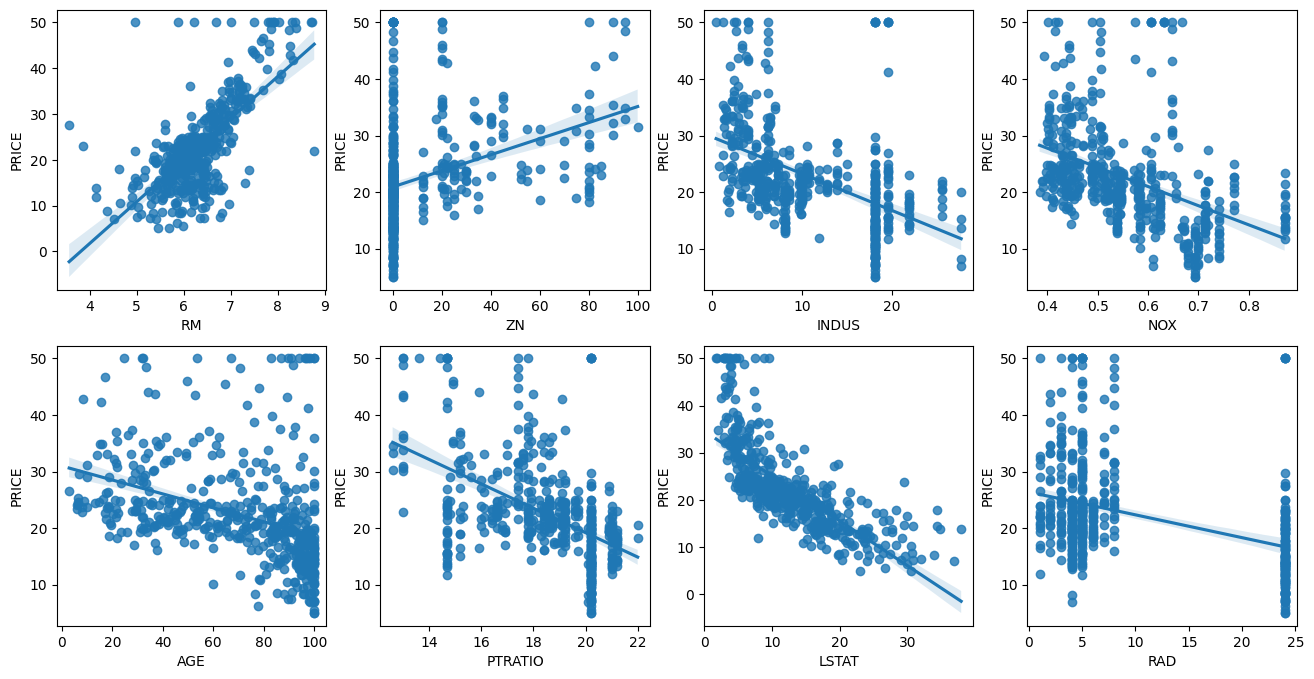

In [12]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i / 4)
    col = i % 4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(
      X_data
    , y_target
    , test_size=0.3
    , random_state=156
)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [14]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216436
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [15]:
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
B           0.0
TAX        -0.0
AGE         0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [16]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace=False)
lr = LinearRegression()

neg_mse_scores = cross_val_score(
      lr
    , X_data
    , y_target
    , scoring='neg_mean_squared_error'
    , cv=5
)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds 의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 folds 의 개별 RMSE scores :', np.round(rmse_scores, 2))
print('5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds 의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds 의 개별 RMSE scores : [3.53 5.1  5.75 8.99 5.77]
5 folds 의 평균 RMSE : 5.829


## 05 다항 회귀와 과(대)적합/과소적합 이해
#### 다항 회귀 이해

In [17]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 피처:\n', X)

poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 피처:\n', poly_ftr)

일차 단항식 계수 피처:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [18]:
def polynomial_func(X):
    y = 1 + 2 * X[:, 0] + 3 * X[:, 0] ** 2 + 4 * X[:, 1] ** 3
    return y

X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 feature:\n', X)
y = polynomial_func(X)
print('삼차 다항식 결정값:\n', y)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
삼차 다항식 결정값:
 [  5 125]


In [19]:
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature:\n', poly_ftr)

model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수\n', np.round(model.coef_, 2))
print('Polynomial 회귀 Shape:', model.coef_.shape)

3차 다항식 계수 feature:
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape: (10,)


In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2 * X[:, 0] + 3 * X[:, 0] ** 2 + 4 * X[:, 1] ** 3
    return y

model = Pipeline([('poly', PolynomialFeatures(degree=3))
                   , ('linear', LinearRegression())])
X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)

model = model.fit(X, y)

print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


#### 다항 회귀를 이용한 과소적합 및 과적합 이해

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

y = true_fun(X) + np.random.randn(n_samples) * 0.1


Degree 1 회귀 계수는 [-1.61] 입니다.
Degree 1 MSE는 0.40772896250986845 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다.
Degree 4 MSE는 0.0432087498723184 입니다.

Degree 15 회귀 계수는 [-2.98294000e+03  1.03899850e+05 -1.87416981e+06  2.03717199e+07
 -1.44874017e+08  7.09319141e+08 -2.47067173e+09  6.24564702e+09
 -1.15677216e+10  1.56895933e+10 -1.54007040e+10  1.06457993e+10
 -4.91381016e+09  1.35920643e+09 -1.70382078e+08] 입니다.
Degree 15 MSE는 182581084.8263125 입니다.


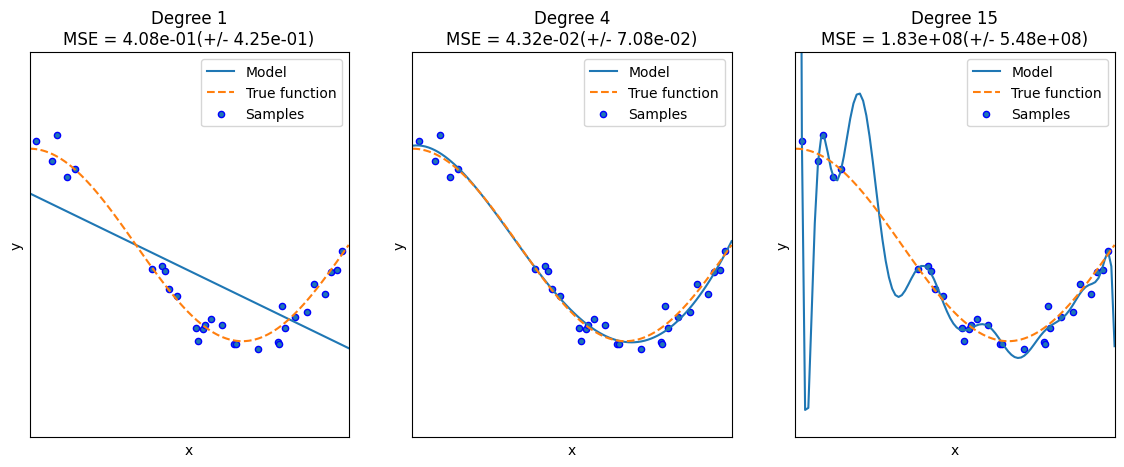

In [22]:
plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([('polynomial_features', polynomial_features)
                         , ('linear_regression', linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)
    
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring='neg_mean_squared_error', cv=10)
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients, 2)))
    print('Degree {0} MSE는 {1} 입니다.'.format((degrees[i]), -1 * np.mean(scores)))
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label='Model')
    plt.plot(X_test, true_fun(X_test), '--', label='True function')
    plt.scatter(X, y, edgecolors='b', s=20, label='Samples')
    
    plt.xlabel('x'); plt.ylabel('y'); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc='best')
    plt.title('Degree {}\nMSE = {:.2e}(+/- {:.2e})'.format(degrees[i], -scores.mean(), scores.std()))

plt.show()

#### 편향-분산 트레이드오프(Bias-Variance Trade off)

## 06 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
#### 규제 선형 모델의 개요
#### 릿지 회귀

In [23]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(
      ridge
    , X_data
    , y_target
    , scoring='neg_mean_squared_error'
    , cv=5
)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


In [24]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    neg_mse_scores = cross_val_score(
          ridge
        , X_data
        , y_target
        , scoring='neg_mean_squared_error'
        , cv=5
    )
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330


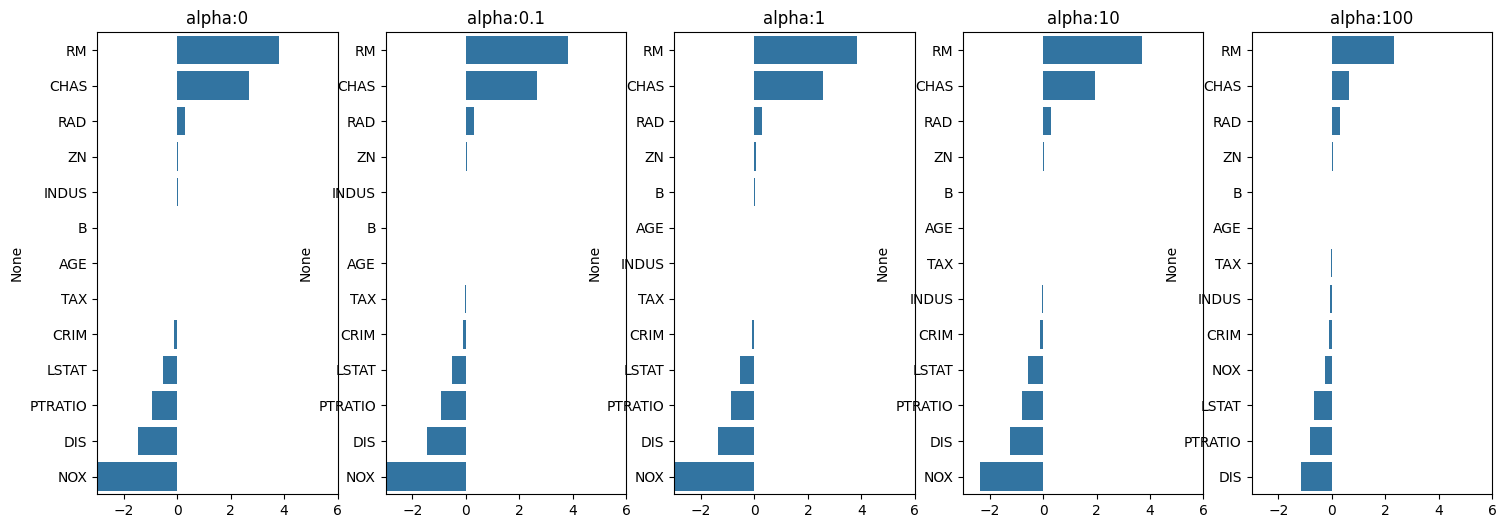

In [25]:
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:' + str(alpha)
    coeff_df[colname] = coeff
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

In [27]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


#### 라쏘 회귀

In [28]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose: print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(
              model
            , X_data_n
            , y_target_n
            , scoring='neg_mean_squared_error'
            , cv=5
        )
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
        
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            coeff = pd.Series(
                  data=model.coef_
                , index=X_data_n.columns
            )
            colname = 'alpha:' + str(param)
            coeff_df[colname] = coeff
    
    return coeff_df

In [29]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval(
      'Lasso'
    , params=lasso_alphas
    , X_data_n=X_data
    , y_target_n=y_target
)

###### Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [30]:
sort_column = 'alpha:' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


#### 엘라스틱넷 회귀

In [32]:
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval(
      'ElasticNet'
    , params=elastic_alphas
    , X_data_n=X_data
    , y_target_n=y_target
)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [33]:
sort_column = 'alpha:' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


#### 선형 회귀 모델을 위한 데이터 변환

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [37]:
alphas = [0.1, 1, 10, 100]

scale_methods = [
    (None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)
]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(
          method=scale_method[0]
        , p_degree=scale_method[1]
        , input_data=X_data
    )
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval(
        'Ridge'
        , params=alphas
        , X_data_n=X_data_scaled
        , y_target_n=y_target
        , verbose=False
        , return_coeff=False
    )


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.770

## 07 로지스틱 회귀

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(
      data_scaled
    , cancer.target
    , test_size=0.3
    , random_state=0
)

In [40]:
from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

print(f'accuracy: {accuracy_score(y_test, lr_preds):.3f}, roc_auc: {roc_auc_score(y_test, lr_preds):.3f}')

accuracy: 0.977, roc_auc: 0.972


In [41]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    
    print(f'solver: {solver}, accuracy: {accuracy_score(y_test, lr_preds):.3f}, roc_auc: {roc_auc_score(y_test, lr_preds):.3f}')

solver: lbfgs, accuracy: 0.977, roc_auc: 0.972
solver: liblinear, accuracy: 0.982, roc_auc: 0.979
solver: newton-cg, accuracy: 0.977, roc_auc: 0.972
solver: sag, accuracy: 0.982, roc_auc: 0.979
solver: saga, accuracy: 0.982, roc_auc: 0.979


In [42]:
from sklearn.model_selection import GridSearchCV

params = {
      'solver': ['liblinear', 'lbfgs']
    , 'penalty': ['l2', 'l1']
    , 'C': [0.01, 0.1, 1, 1, 5, 10]
}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print(f'최적 하이퍼 파라미터: {grid_clf.best_params_}, 최적 평균 정확도: {grid_clf.best_score_:.3f}')

최적 하이퍼 파라미터: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도: 0.979
